# Importing Libraries

In [ ]:
from functions.adversarial import *
from functions.dip import *
from functions.classification import *
import matplotlib.pyplot as plt
import cv2
import numpy as np
from functions.utils import *

#device = torch.device("cuda" if torch.cuda.device_count() else "cpu")

# Fast Gradient Descent Method

In [ ]:
adv1, orig, pert = adversarial_examples('data/goldfish.jpg', method='FGSM',eps=100,show=False)

# Basic Iterative Method

In [ ]:
adv2, orig, pert = adversarial_examples('data/goldfish.jpg',method='BI',eps=100,show=False)

# Least Likely Class Iterative

In [ ]:
adv3, orig, pert = adversarial_examples('data/goldfish.jpg',method='LLCI',eps=100,show=False)

## Some plotting

In [ ]:
fig=plt.figure(figsize=(16,16))

fig.add_subplot(1, 3, 1)
plt.title('FGSM')
plt.imshow(adv1)

fig.add_subplot(1, 3, 2)
plt.title('BI')
plt.imshow(adv2)

fig.add_subplot(1, 3, 3)
plt.title('LLCI')
plt.imshow(adv3)

plt.show()

## Save images
plt.imsave("results/Goldfish_fgsm_eps100.png", adv1, format="png")
plt.imsave("results/Goldfish_bi_eps100.png", adv2, format="png")
plt.imsave("results/Goldfish_llci_eps100.png", adv3, format="png")

# Using Deep Image Prior

In [ ]:
orig = cv2.imread("data/lighthouse.jpg")[..., ::-1]
orig = cv2.resize(orig, (256, 256))
img = orig.copy().astype(np.float32)

## Save images
#plt.imsave("results/F16_noisy.png", np.clip(img_noisy, 0, 1), format="png")
#plt.imsave("results/F16.png", np.clip(img, 0, 1), format="png")

dip_out = dip(img, num_iter=10001, save=False, plot=False, save_path='results/Adv_DIP/', arch='complex')

# Observing general images

In [ ]:
i=20
orig = cv2.imread("results/Adv_DIP/FGSM_eps100/it_{}.png".format(i*100))[..., ::-1]
orig = cv2.resize(orig, (256, 256))
img = orig.copy().astype(np.float32)
P,R = classification(img)
plt.imshow(orig) 

In [ ]:
std = 150
value = 100

adv, orig, pert = adversarial_examples('data/goldfish.jpg',model_name = 'resnet18', method='FGSM',eps=value, show=False)
adv_noisy = adv + std*np.random.randn(224,224,3)
adv_noisy = np.clip(adv_noisy,0,255).astype(np.uint8)
plt.imshow(adv_noisy)
plt.show()

In [ ]:
it_300 = cv2.imread("results/Adv_DIP/LLCI_eps5/it_{}.png".format(300))[..., ::-1]
it_1200 = cv2.imread("results/Adv_DIP/LLCI_eps5/it_{}.png".format(1200))[..., ::-1]
it_2500 = cv2.imread("results/Adv_DIP/LLCI_eps5/it_{}.png".format(5000))[..., ::-1]
orig = cv2.imread('data/panda.jpg')[...,::-1]

P,R = classification(orig)
P,R = classification(it_300)
P,R = classification(it_1200)
P,R = classification(it_2500)

## Classifying

In [ ]:
# Find original classification class
iterations = 9101
#adv, orig, pert = adversarial_examples('data/goldfish.jpg',model_name = 'resnet18', method='LLCI',eps=100, show=False)
P, R = classification(orig, model_name = 'resnet18', sort = True, show=False)
original_class = R[0,0]
P, R = classification(adv, model_name = 'resnet18', sort = True, show=False)
final_classes = R[0,0:5]

# Create matrix to store values
Confidence = np.ones([round((iterations-1)/100+1),6])
Ranks_matrix = np.ones([round((iterations-1)/100+1),5])


for i in range(round((iterations-1)/100+1)):
    orig = cv2.imread("results/Adv_DIP/Complex_LLCI_eps5/it_{}.png".format(i*100))[..., ::-1]
    orig = cv2.resize(orig, (256, 256))
    img = orig.copy().astype(np.float32)
    Probs, Ranks = classification(img, model_name = 'resnet18', sort = False, show = False)
    Probs_np = torch_to_np(Probs)
    Confidence[i,0] = Probs_np[original_class]
    P , Ranking = Probs.sort(descending=True)
    Ranking_np = torch_to_np(Ranking)
    for j in range(5):
        Confidence[i,j+1] = Probs_np[final_classes[j]]
        Ranks_matrix[i,j] = Ranking_np[j]  

In [ ]:
it = np.arange(0, iterations+99, 100)
iters = round((iterations-1)/100+1)
fig = plt.figure(figsize=(6, 6))
plt.xlabel('DIP Iterations')
plt.ylabel('Confidence of true class')
plt.plot(it,Confidence)
plt.show()

# Save stuff
fig.savefig('results/Adv_DIP/Simple_LLCI_eps5/Graph_Complex_LLCI_eps100_full.png')
np.savetxt('results/Adv_DIP/Simple_LLCI_eps5/Complex_LLCI_eps100_full.txt', Confidence)
np.savetxt('results/Adv_DIP/Simple_LLCI_eps5/Complex_LLCI_eps100_ranks.txt', Ranks_matrix)
for i in range(5):
    print(classes[int(Ranks_matrix[-1,i])].split(',')[0])

Method: Fast Gradient Sign Method
Model: resnet18 

Prediction before attack:

Top 5 classes                 Confidence

giant panda                      0.98848
indri                            0.00578
teddy                            0.00114
lesser panda                     0.00035
Madagascar cat                   0.00033


After attack: eps [1.000000] alpha [1.000000]

Top 5 classes                 Confidence

giant panda                      0.46281
indri                            0.37312
Madagascar cat                   0.02269
teddy                            0.01686
gibbon                           0.00870


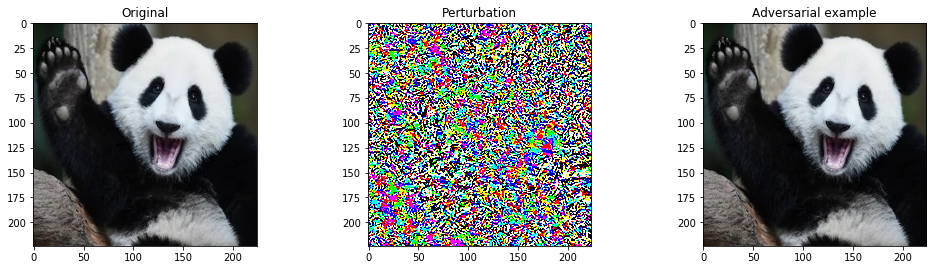

Number of params: 113311
Starting optimization with ADAM


C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


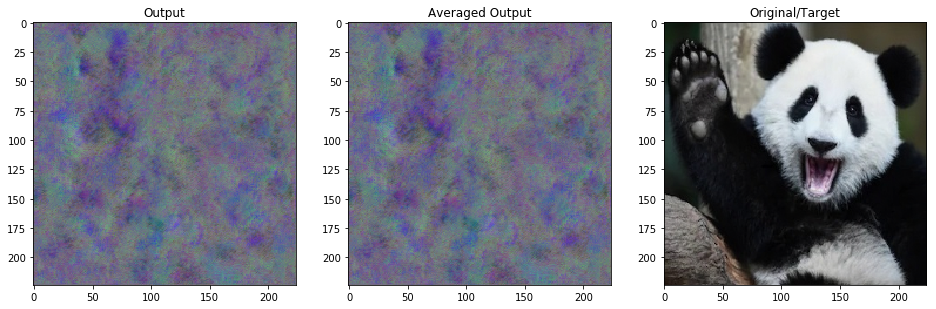

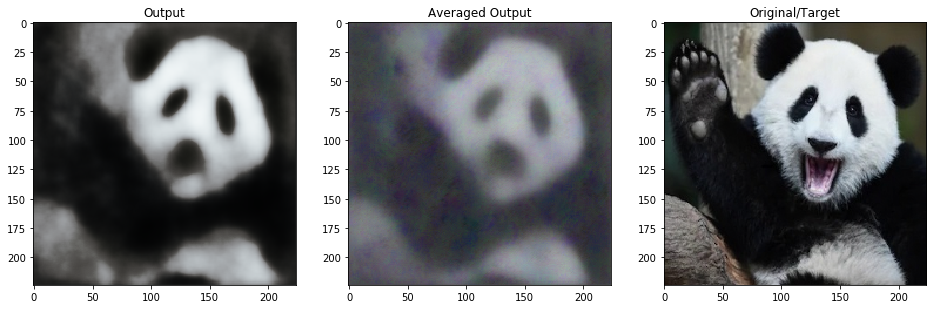

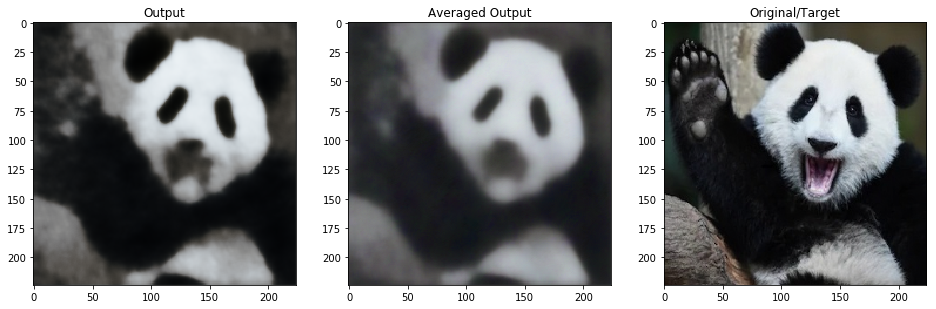

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
#import argparse
import numpy as np
from functions.utils import *
from functions.adversarial import *
from functions.dip import *
from functions.classification import *
import torch

images = ['panda.jpg']    #,'peacock.jpg','F16_GT.png','monkey.jpg','zebra_GT.png']
for i in images:
    adv, orig, pert = adversarial_examples("data/{}".format(i), method = "FGSM", eps=1, show=True)
    out = dip(adv, num_iter=201, save=False, plot=True, save_path='results/Adv_DIP/{}'.format(i), arch='simple')

In [2]:
out

tensor([[[[0.2345, 0.2285, 0.2256,  ..., 0.2416, 0.2400, 0.2188],
          [0.2054, 0.1978, 0.1888,  ..., 0.2163, 0.2105, 0.1928],
          [0.2055, 0.1911, 0.1805,  ..., 0.2157, 0.2096, 0.1969],
          ...,
          [0.2182, 0.2091, 0.2053,  ..., 0.1256, 0.1228, 0.1481],
          [0.2146, 0.2036, 0.2001,  ..., 0.1366, 0.1355, 0.1480],
          [0.2264, 0.2057, 0.2045,  ..., 0.1492, 0.1559, 0.1672]],

         [[0.2416, 0.2301, 0.2226,  ..., 0.2523, 0.2388, 0.2228],
          [0.2127, 0.1954, 0.1878,  ..., 0.2241, 0.2099, 0.1979],
          [0.1974, 0.1830, 0.1827,  ..., 0.2241, 0.2150, 0.1952],
          ...,
          [0.2132, 0.2092, 0.2104,  ..., 0.1277, 0.1346, 0.1481],
          [0.2108, 0.2093, 0.2033,  ..., 0.1364, 0.1357, 0.1542],
          [0.2249, 0.2034, 0.2058,  ..., 0.1586, 0.1658, 0.1731]],

         [[0.2357, 0.2254, 0.2263,  ..., 0.2529, 0.2389, 0.2232],
          [0.2075, 0.2004, 0.1906,  ..., 0.2165, 0.2073, 0.2059],
          [0.2154, 0.2020, 0.2003,  ..., 0